In [2]:
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from tkinter import ttk, filedialog
from tkinter.filedialog import askopenfile

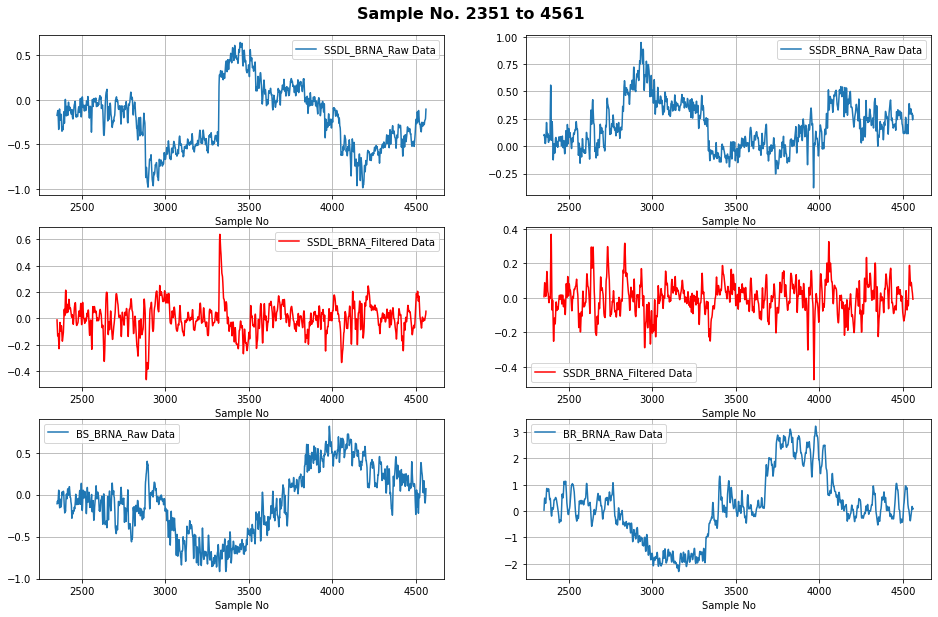

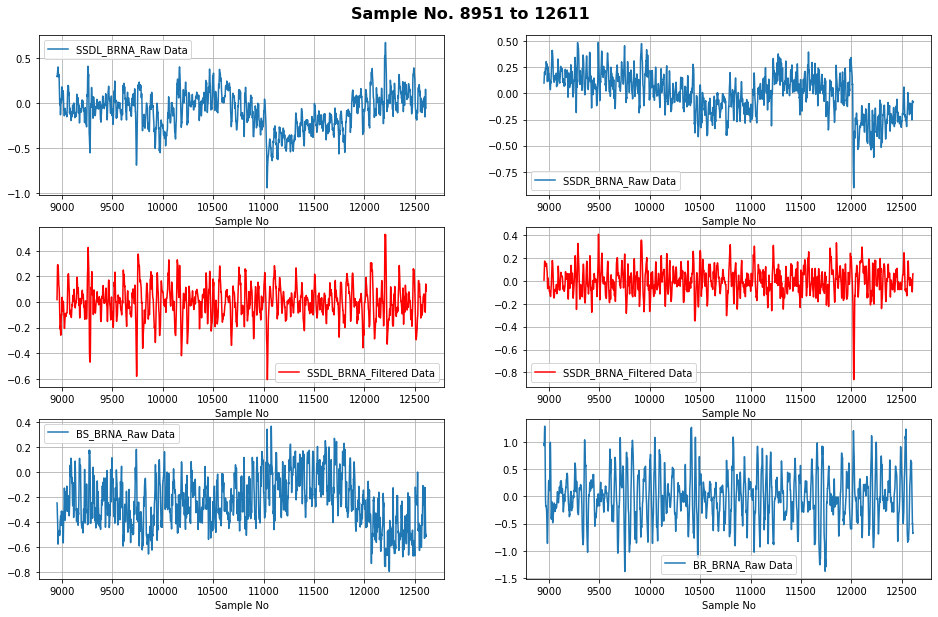

In [5]:
global segment
m=tk.Tk()
ttk.Style().configure('TLabel', anchor='w')
m.title('Spring Analysis')
ttk.Label(m, text='Select Raw Data File').grid(row=0)
e1=ttk.Entry(m)
e1.grid(row=0,column=1)
ttk.Button(m, text='Browse...', command=get_raw_data).grid(row=0,column=2)
ttk.Label(m, text='Enter Secondary Spring Channels Separated by comma').grid(row=1)
e2 = ttk.Entry(m)
e2.insert(0,'7,8')
e2.grid(row=1,column=1)
ttk.Label(m, text='Enter BS & BR Channels Separated by comma').grid(row=2)
e3 = ttk.Entry(m)
e3.insert(0,'9,10')
e3.grid(row=2, column=1)
ttk.Label(m, text='Enter Bogie Radius in mm').grid(row=3)
e4 = ttk.Entry(m)
e4.insert(0,1100)
e4.grid(row=3, column=1)
ttk.Label(m, text='Sampling Rate').grid(row=4)
e5 = ttk.Entry(m)
e5.insert(0,100)
e5.grid(row=4, column=1)
ttk.Label(m, text='Filter Type').grid(row=5)
ft=ttk.Combobox(m, width=17)
ft['values']=['Bandpass','Highpass','Lowpass']
ft.current(0)
ft['state']='readonly'
ft.grid(row=5, column=1)
ttk.Label(m, text='Lower Cut-Off Frequency').grid(row=6)
e6 = ttk.Entry(m)
e6.insert(0,0.4)
e6.grid(row=6, column=1)
ttk.Label(m, text='Higher Cut-Off Frequency').grid(row=7)
e7 = ttk.Entry(m)
e7.insert(0,10)
e7.grid(row=7, column=1)
ttk.Label(m, text='Filter Order').grid(row=8)
e8 = ttk.Entry(m)
e8.insert(0,2)
e8.grid(row=8, column=1)
ttk.Label(m, text='Please Choose Sample Numbers', anchor='s',width=60).grid(row=9,columnspan=3,ipady=10)
var1=tk.IntVar(value=1)
r1 = ttk.Radiobutton(m, text="Select Segment File", variable= var1, value=1,command=lambda : sec(var1.get()))
r1.grid(row=10, column=0)
e11=ttk.Entry(m)
e11.grid(row=10,column=1)
b1=ttk.Button(m, text='Browse...', command=get_segment)
b1.grid(row=10,column=2,padx=5)
r2 = ttk.Radiobutton(m, text="Enter Manually", variable= var1, value=2, command=lambda : sec(var1.get()))
r2.grid(row=11, column=0)
ttk.Label(m,text="Sample Start").grid(row=12,column=0)
ttk.Label(m,text="Sample End").grid(row=12,column=1)
e9=ttk.Entry(m)
e9.grid(row=13,column=0)
e9.configure(state='disabled')
e10=ttk.Entry(m)
e10.grid(row=13,column=1)
e10.configure(state='disabled')
ttk.Button(m, text='Calculate', command=calculation).grid(row=14,column=0,columnspan=3)
m.mainloop()

In [4]:
def get_raw_data():
    global data
    global file
    file = tk.filedialog.askopenfile(mode='r')
    if file:
        e1.insert(0, file.name)
        data=pd.read_csv(file.name, sep='\t', lineterminator='\n')
        file.close()

def get_entries():
    ssd_channels=[int(i) for i in e2.get().split(',')]
    bsbr_channels=[int(i) for i in e3.get().split(',')]
    bogie_radius=float(e4.get())
    fs=int(e5.get())
    return ssd_channels, bsbr_channels, bogie_radius, fs

def get_filter_data():
    filter_type=ft.get()
    lowcut=float(e6.get())
    highcut=float(e7.get())
    order=int(e8.get())
    return filter_type, lowcut, highcut, order

def sec(v):
    if(v==1):
        e11.configure(state='normal')
        b1.config(state='normal')
        e9.configure(state='disabled')
        e10.configure(state='disabled')
    if(v==2):
        e9.configure(state='normal')
        e10.configure(state='normal')
        e11.configure(state='disabled')
        b1.config(state='disabled')
               
def get_segment():
    global file1
    file1 = tk.filedialog.askopenfile(mode='r')
    if file1:
        e11.insert(0, file1.name)
        file1.close()

# Calculation of filtered data and storing the results in the required format
def calculation():
    result=pd.DataFrame(columns=['Max ON', 'Max OFF', 'BS', 'BR'])
    ssd_channels, bsbr_channels, bogie_radius, fs = get_entries()
    filter_type, lowcut, highcut, order = get_filter_data()
    if var1.get()==2:
        segment=pd.DataFrame([[int(e9.get()),int(e10.get())]])
    else:
        segment=pd.read_csv(file1.name, sep='\t', lineterminator='\n')
    for i in range(len(segment)):
        section=[x for x in segment.iloc[i,:]]
        ssd_sec=data.iloc[section[0]:section[1],ssd_channels]
        bsbr_sec=data.iloc[section[0]:section[1],bsbr_channels]
    
        b, a = butter(N=order, Wn=[lowcut, highcut], fs=fs, btype = filter_type)
        filtered_ssd_sec = np.array(lfilter(b, a, ssd_sec.values, axis=0))
        
        plot_graphs(section, ssd_sec, filtered_ssd_sec, bsbr_sec)
    
        bsbr_sec_max=bsbr_sec.abs().max().values
        res=[abs(filtered_ssd_sec.min()),abs(filtered_ssd_sec.max()),bsbr_sec_max[0],bsbr_sec_max[1]*(180/(bogie_radius*np.pi))]
        result=pd.concat([result,pd.DataFrame(np.array(res).reshape(1,4),columns=['Max ON', 'Max OFF', 'BS', 'BR'])])
    result.to_csv("Result_"+ Path(file.name).name, sep='\t', index=False)
    tk.messagebox.showinfo("Success", "Result File has been saved as Result_"+Path(file.name).name)

In [3]:
# Plotting raw and filtered section data.
def plot_graphs(section, ssd_sec, filtered_ssd_sec, bsbr_sec):
    fig=plt.figure(figsize=(16,10))
    fig.suptitle("Sample No. {} to {}".format(section[0],section[1]), fontsize='16', weight='heavy', y=0.92)
    plt.subplot(3,2,1)
    plt.plot(np.arange(section[0],section[1]), ssd_sec.values[:,0], label=ssd_sec.columns[0]+'_Raw Data')
    plt.xlabel('Sample No')
    plt.grid(True)
    plt.legend(loc='best')
    
    plt.subplot(3,2,2)
    plt.plot(np.arange(section[0],section[1]), ssd_sec.values[:,1], label=ssd_sec.columns[1]+'_Raw Data')
    plt.xlabel('Sample No')
    plt.grid(True)
    plt.legend(loc='best')
        
    plt.subplot(3,2,3)
    plt.plot(np.arange(section[0],section[1]), filtered_ssd_sec[:,0], label=ssd_sec.columns[0]+'_Filtered Data', color='r')
    plt.xlabel('Sample No')
    plt.grid(True)
    plt.legend(loc='best')
        
    plt.subplot(3,2,4)
    plt.plot(np.arange(section[0],section[1]), filtered_ssd_sec[:,1], label=ssd_sec.columns[1]+'_Filtered Data', color='r')
    plt.xlabel('Sample No')
    plt.grid(True)
    plt.legend(loc='best')
        
    plt.subplot(3,2,5)
    plt.plot(np.arange(section[0],section[1]), bsbr_sec.values[:,0], label=bsbr_sec.columns[0]+'_Raw Data')
    plt.xlabel('Sample No')
    plt.grid(True)
    plt.legend(loc='best')
        
    plt.subplot(3,2,6)
    plt.plot(np.arange(section[0],section[1]), bsbr_sec.values[:,1], label=bsbr_sec.columns[1]+'_Raw Data')
    plt.xlabel('Sample No')
    plt.grid(True)
    #plt.axis('auto')
    plt.legend(loc='best')
    plt.show()